# Quantum Game Theory

In [66]:
#Run this cell once to load all the relevant packages and settings
%load_ext autoreload
%autoreload 2

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
from qiskit.extensions import XGate, HGate
from QuantumGameTheory import Game
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cool picture

## What you will learn in this tutorial

Fun intro - teach you how to be a quantum game creator
* What is a qubit and what are unitary gates
* What is a "Game Theory" game
* What is a "Quantum Game theory" game and how can I study these types of games using qiskit

## Prerequisits
If already know qubits, unitary operators and measurements -> skip to Game 
qubit - (-> interference)
unitary operators (-> entanglement)
measurements (-> collapse theory?)
-> demos through qiskit but not

## Game Theory
intro w/ John Nash (rec letter). Players play a game in which they make choices (i.e. pick strategies) in order to maximize their points (i.e. their payoffs). The best way to get introduced to game theory is to start playing a game, soo let's dive straight in! 

### The Prisoner's dilemma

Probably the most famous game theoretical game is the [Prisoner's Dilema](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma). There are many variants to this game each with their own story, so here's our story for the game:

Both you and I team up to break into a zoo and steal a panda (just for a little bit, we were going to give it back!). Unfortunately we both get caught, but not quite redhanded, so it isn't such an open-and-shut case for the police. So in order to try and get a confession out of both of us, the police seperate us into different rooms and give each of us two options:
* To remain silent and take our chances - we shall call this strategy '0'
* To confess and maybe receive a reduced sentence - we shall call this strategy '1'

So together, there are 4 possible outcomes that could happen: '00' (where we both remain silent), '01' (where you remain silent and I confess), '10' (where you confess and I remain silent) and '11' (where we both confess).
We are told that if we both remain silent (i.e. end up at the '00' outcome), the police still have enough evidence sentence us to 1 month in prison. However, if one of us confesses (i.e. the outcome is either '01' or '10') the player who chose the '1' strategy goes free and the other player (who chose the strategy '0') receives a 3 month prison sentence. "What if we both confess, i.e. the outcome is '11'?" I hear you ask. In which case, the policement informs us that we each get a 2 month prison sentence. I know there's a lot going on, so don't worry if you can't remember it all. It will become much clearer as we start coding right now!

Finally, on to some coding! So withouth further ado, let us create the prisoner's dilemma game object by simply calling it:

In [55]:
prisoner_game = Game(game_name='prisoner',protocol="Classical")

The 'game_name' indicates which game to load. Don't worry about the 'protocol' for now (as you might have guessed, we will use this later on when making a quantum version of the game). Now before we play the game, let's have a look at the possible payoffs

In [56]:
prisoner_game.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


This shows us the outcomes represented in bits and the payoff for each outcome e.g. if you remain silent ('0') and I confess ('1'), the outcome is represented by the bits '01' and the corresponding payoff is '[-3, 0]' which indicates that you will be sentenced to 3 months prison and I will go free (i.e. get 0 months prison). Notice that the payoff for you is -3 and not 3. This is because players are always trying to maximize their payoff, so the more months in prison will give you more negative results. 

So let's play! You will be P1 and I will be P2. To run the game, we simply have to input our strategies into the 'play_game' method and the results will be displayed. Feel free to try the different strategies for both players (and don't worry about the 'num_times' column for now). 

In [58]:
P1_strategy = #fill in here
P2_strategy = 1
combined_strategies = [P1_strategy, P2_strategy]
prisoner_game.play_game(combined_strategies)

,outcome,payoffs,winners,num_times
0,01,"(-3, 0)",P2,1


Exercise: What strategy would you choose if you didn't know what strategy I was going to choose? This can be a bit tricky but it is worth taking the time to think about it before looking at the answer!

<details>
<summary>Click here for the answer</summary>
No matter what strategy I choose, the optimal strategy for you is 1 (i.e. to confess). To understand this, let's look at the options starting with my strategies:
<ol>
  <li>I choose strategy 0 i.e. remain silent. If you also choose 0, your payoff is -1 whereas if you choose 1, your payoff is 0. Therefore it is better for you to choose 1 in this case.</li>
  <li>I choose strategy 1 i.e. confess. If you choose 0, your payoff is -3 whereas if you also choose 1, your payoff is -2. Therefore it is also better for you to choose 1 in this case.</li>
</ol>
So it is always better for you to choose 1. By symmetry, this logic works for both of us (i.e. it is also better for me to always choose 1 since if I become P1 and you become P2, nothing changes). Therefore, rationally speaking, we should both always choose option 1. This leads to the concept of the 'dominant strategy' - the strategy that we will choose regardless of what the other person chooses (in this case 1 for the both of us). We say that this game has a 'dominant strategy equilibrium state' with the outcome 11 and payoffs [-2, -2].  
</details>

The prisoner's dilemma is known as a "2x2 game" - a game in which there are 2 players and they each have a the option between 2 strategies. So immediately we can see how to make any 2x2 game in principle - just make a list of payoffs and you now have a game! So let's do it

In [59]:
my_game_name = '' #fill in game name
my_payoff_table = {'00': [#, #], 
                   '01': [#, #],
                   '10': [#, #],
                   '11': [#, #]} #fill in payoffs
my_game = Game(my_game_name, protocol="Classical", payoff_table=my_payoff_table)
my_game.display_payoffs()

Game: cake fam
Payoffs: 


,outcome,payoffs
0,00,"[1, 1]"
1,01,"[1, 1]"
2,10,"[1, 1]"
3,11,"[1, 1]"


In [61]:
P1_choice = #fill in here
P2_choice = #fill in here
choices = [P1_choice, P2_choice]
my_game_game.play_game(choices)

,outcome,payoffs,winners,num_times
0,01,"(-3, 0)",P2,1


Here ends our introduction to Game Theory. There are [many](https://www.youtube.com/watch?v=3Y1WpytiHKE), [many](http://web.mit.edu/rgibbons/www/Gibbons_An%20Introduction%20to%20Applicable%20Game%20Theory.pdf) [good](http://www.rasmusen.org/GI/download.htm) [resources](https://econweb.ucsd.edu/~jsobel/200Cs09/Kartik_Notes.pdf) out there to learn more about classical game theory. As far as this tutorial is concerned, we will end our discussion on classical game theory here. Now let's go quantum!

## Quantum Game Theory
1. Qubits instead of bits
2. Entangle the qubits
2. Strategies are unitary operators
3. Outcome is a measurement of our qubits after the strategies
4. Use the same payoff table to find payoff for each player


### EWL protocol
EWL protocol w/ 2 prequisits - max entanglement and generalization of classical game. again with example

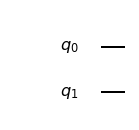

In [77]:
#2 x 2 quantum game, each player gets two qubits, with the states |0> and |1> representing classical strategies '0' and '1'.
#Start with qubits
circ = QuantumCircuit(2)
circ.draw(output='mpl')

Next, maximally entangled states -> full correlation
we will choose |00> + i|11> (i comes from historical, beamsplitter stuff?)
Need 1/sqrt(2)(Ix2 + iXx2)
Build our own gate!

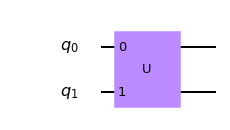

In [78]:
I_2 = np.identity(4)
    
X_2 = np.matrix([[0,0,0,1], 
                   [0,0,1,0],
                   [0,1,0,0],
                   [1,0,0,0]])
J_2 = Operator(1 / np.sqrt(2) * (I_2 + 1j *X_2))    

circ.append(J_2, [0,1])
circ.draw(output='mpl')

exercise: encourage you to do Ix2 and Xx2 and finally J_2
under the hood: we can do it for arbitray number of players   

Each person can perform a unitary operator on their qubit.
E.g. player 1 chooses X and player 2 chooses H

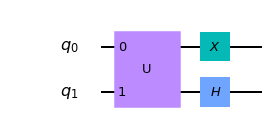

In [79]:
circ.x(0)
circ.h(1)
circ.draw(output='mpl')

So we have the maximum entanglement and we have quantum strategies. Just measure and done? Nope, we have to add another gate because of subtle point of generalization of classical game

Generalization should be that if players only use I or X, it should mimic classical game -> need 'unentangling' gate. It is dagger of original J gate

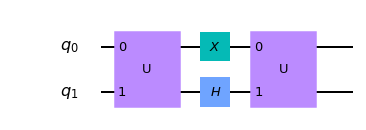

In [80]:
J_2_dg = Operator(1 / np.sqrt(2) * (I_2 - 1j *X_2))

circ.append(J_2_dg, [0,1])
circ.draw(output='mpl')

Now we measure to get outcome, and get payoff using payoff table. Let's look at prisoner's dilemma example again but this time quantum EWL

### Quantum Prisoner's Dilemma

In [81]:
prisoner_game_quantum = Game(game_name='prisoner',protocol="EWL")
prisoner_game_quantum.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


generate the same circuit with same strategies (X and H)

In [84]:
P1_strategy = 'X'
P2_strategy = 'H'
combined_strategies = [P1_strategy, P2_strategy]
prisoner_game_quantum.play_game(combined_strategies)

,outcome,payoffs,winners,num_times
0,11,"(-2, -2)",no winners,1


Look at circuit again and calculate by hand
calculation of final state
so why does the above show a single outcome? Remember, the last step is a measurement! Let's do it several times -> back to the num_times I asked you to ignore!

In [85]:
prisoner_game_quantum.play_game(combined_strategies, n_times = 100)

,outcome,payoffs,winners,num_times
0,10,"(0, -3)",P1,23
1,01,"(-3, 0)",P2,23
2,00,"(-1, -1)",no winners,33
3,11,"(-2, -2)",no winners,21


Different outcomes every time! Exercise: do the measurements correspond with probabilities?

In [ ]:
Q prisoner's dilemma has other optimal strategies that don't exist in classical -> Nash equilibriums!
(x-minority game)
other current features ('MW' protocol, etc.)

## What next?
This is really cool, what can I do going forward?
1. Help build infrastructure - mixed strategies, more choices etc.
2. Study theory using this toolkit
Ideas we are interested in/working on
Get in touch with us!